# Load tuner session

In [14]:
import keras_tuner
import tune_keras_class as tkc

# Assuming LOG_DIR is defined in your script as it was used in the tuning session
LOG_DIR = f"hyperband_54h"

# Load the tuner
tuner = keras_tuner.Hyperband(
    hypermodel=tkc.PmsmHyperModel(),
    objective='val_loss',
    # executions_per_trial=1,
    factor=4,
    hyperband_iterations=3,
    overwrite=False,
    directory=LOG_DIR,
    project_name='hyperband',)
# Now you can use the tuner object to access the tuning session results or continue the search
# For example, to get the best models:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

# Or to continue the search:
# tuner.search(**fit_args)

Reloading Tuner from hyperband_54h/hyperband/tuner0.json
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 91)]          0         
                                                                 
 conv1d (Conv1D)             (None, 32, 53)            33814     
                                                                 
 batch_normalization (Batch  (None, 32, 53)            212       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 53)            0         
                                                                 
 spatial_dropout1d (Spatial  (None, 32, 53)            0         
 Dropout1D)                                                      
                                                                 
 glo

# Show top 10 trials of the tuner session

In [15]:
tuner.results_summary(num_trials=10)

Results summary
Results in hyperband_54h/hyperband
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0393 summary
Hyperparameters:
n_layers: 1
n_units: 53
kernel_size: 7
regularization_rate: 2.780121739864642e-08
dropout_rate: 0.33155057064133653
lr_rate: 0.00041103832448635377
tuner/epochs: 7
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0334
Score: 0.007547460030764341

Trial 0415 summary
Hyperparameters:
n_layers: 6
n_units: 112
kernel_size: 5
regularization_rate: 5.740274199875547e-07
dropout_rate: 0.2590930319794237
lr_rate: 0.0012857402548313726
tuner/epochs: 100
tuner/initial_epoch: 25
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0412
Score: 0.009724129922688007

Trial 0412 summary
Hyperparameters:
n_layers: 6
n_units: 112
kernel_size: 5
regularization_rate: 5.740274199875547e-07
dropout_rate: 0.2590930319794237
lr_rate: 0.0012857402548313726
tuner/epochs: 25
tuner/initial_epoch: 7
tuner/bracket: 3
tuner/round: 2
tuner/trial_id

# Load best model of the tuner session

In [16]:
from preprocessing.cnn_model_utils import CNNKerasRegressor

def dummy_build_fn():
    # Load the model architecture from the JSON file
    with open('path_to_your_model.json', 'r') as json_file:
        model_json = json_file.read()
    # model = model_from_json(json_string=model_json)
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = CNNKerasRegressor(build_fn=None)

best_hp = tuner.get_best_hyperparameters()[0]
model.model = tuner.hypermodel.build(best_hp)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 91)]          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 32, 53)            33814     
                                                                 
 batch_normalization_6 (Bat  (None, 32, 53)            212       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 32, 53)            0         
                                                                 
 spatial_dropout1d_6 (Spati  (None, 32, 53)            0         
 alDropout1D)                                                    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 53)                0   

# Load data

In [17]:
import numpy as np
import preprocessing.config as cfg
from preprocessing.data import LightDataManager

# Ensure reproducibility
SEED = cfg.data_cfg["random_seed"]
np.random.seed(SEED)

file_path = 'data/input/8h_run.csv'
dm = LightDataManager(file_path)
dm.featurize()


predict_cfg = {'batch_size': 128,
                'window_size': 32,
                'p_id_col': dm.PROFILE_ID_COL,
                }

# predict
x_tst = dm.tst_df[dm.x_cols + [dm.PROFILE_ID_COL]]
y_tst = dm.tst_df[dm.y_cols]

model.__class__ = CNNKerasRegressor

build dataset ..
111.14253807067871 MB
took 3.24 seconds


# Predict on the test set
*The model has at this point only been trained on the the ressources allocated by HyperBand.*

In [18]:
pred = model.predict(x_tst, **predict_cfg)
pred = dm.inverse_transform(df=pred)
y_tst = dm.inverse_transform(y_tst)

250/250 [==============================] - 2s 6ms/step


# Plot predictions vs ground truth

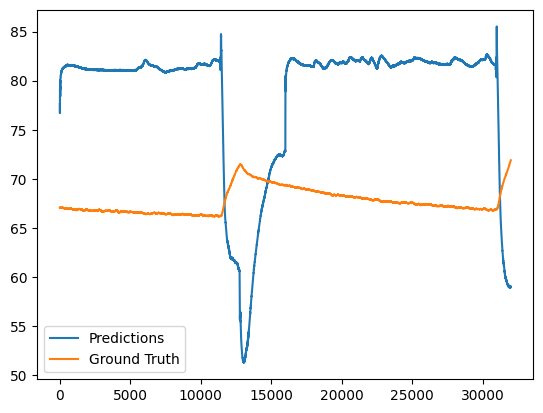

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(pred, label='Predictions')
plt.plot(y_tst, label='Ground Truth')
plt.legend()
plt.show()

# Resume training on the full dataset

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

x_train = dm.tra_df[dm.x_cols + [dm.PROFILE_ID_COL]]
y_train = dm.tra_df[dm.y_cols]
x_val = dm.val_df[dm.x_cols + [dm.PROFILE_ID_COL]]
y_val = dm.val_df[dm.y_cols]

batch_size = cfg.keras_cfg["cnn_params"].get("batch_size")
window_size = cfg.keras_cfg["window_size"]

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        min_delta=1e-3,
        patience=cfg.keras_cfg["early_stop_patience"],
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor="loss", patience=cfg.keras_cfg["early_stop_patience"] // 3
    ),
]


KerasRegressor_config = {
    "x_shape": (cfg.keras_cfg["window_size"], len(dm.x_cols)),
    "verbose": 1,
    "loss": dm.loss_func,
}

fit_cfg = {
    "x": x_train,
    "y": y_train,
    "batch_size": batch_size,
    "window_size": window_size,
    "validation_data": (x_val, y_val),
    "epochs": cfg.keras_cfg["cnn_params"]["epochs"],
    "shuffle": True,
    "callbacks": callbacks,
    "p_id_col": dm.PROFILE_ID_COL,
    # "data_cache": trial_reports.data_cache,
    "x_shape": KerasRegressor_config["x_shape"],
    # "callbacks": [tensorboard_callback]
}

model.fit(**fit_cfg)

ValueError: The first argument to `Layer.call` must always be passed.